In [654]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [655]:
#Set variables that always change during the cleaning
# I just changed for each variable the year and the corresponding S&P500 value
ds2014 = pd.read_csv("dataset/2018_Financial_Data.csv")
price = "2019 PRICE VAR [%]"
fileName = "Cleaned_2018.csv"
outliers_percentage = 300
sp_price_var = 28.88 # -0.73, 9.54, 19.42, -6.24, 28.88
benchmark = 2.5
sp500_2015_buy = sp_price_var + benchmark
sp500_2015_sell = sp_price_var - benchmark

In [656]:
#print(ds2014.info())
#print(ds2014.describe())

/Users/josip/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


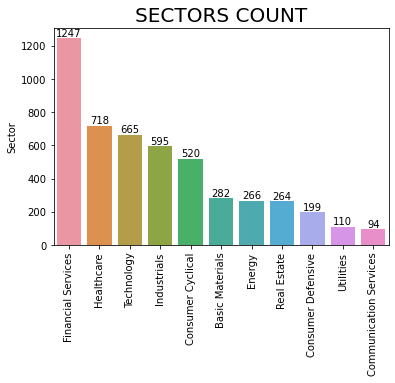

In [657]:
# Plot sector distribution, to see what data do we have
df_sector = ds2014['Sector'].value_counts()
plotSector = sns.barplot(np.arange(len(df_sector)), df_sector)
plotSector.bar_label(plotSector.containers[0])
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.title('SECTORS COUNT', fontsize=20)
plt.show()

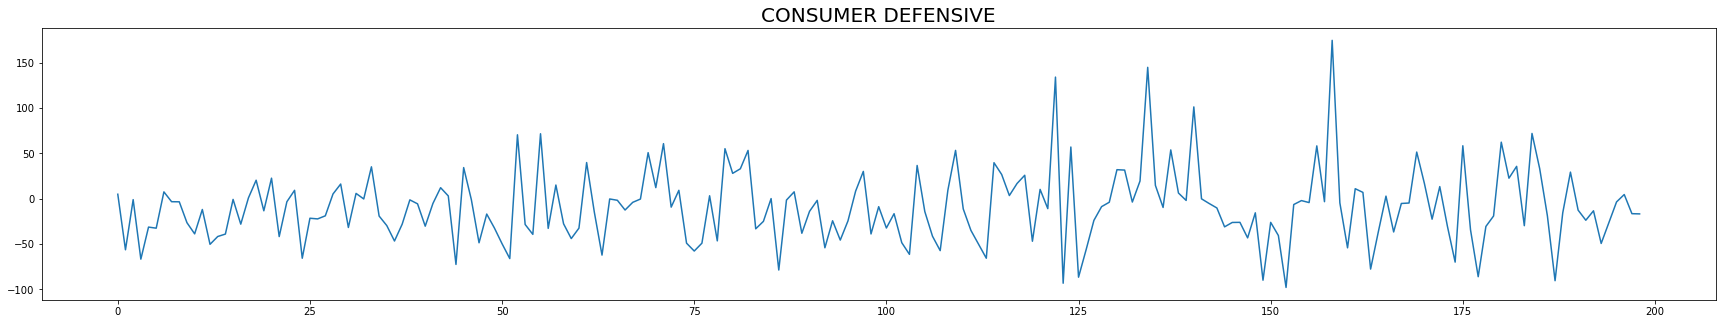

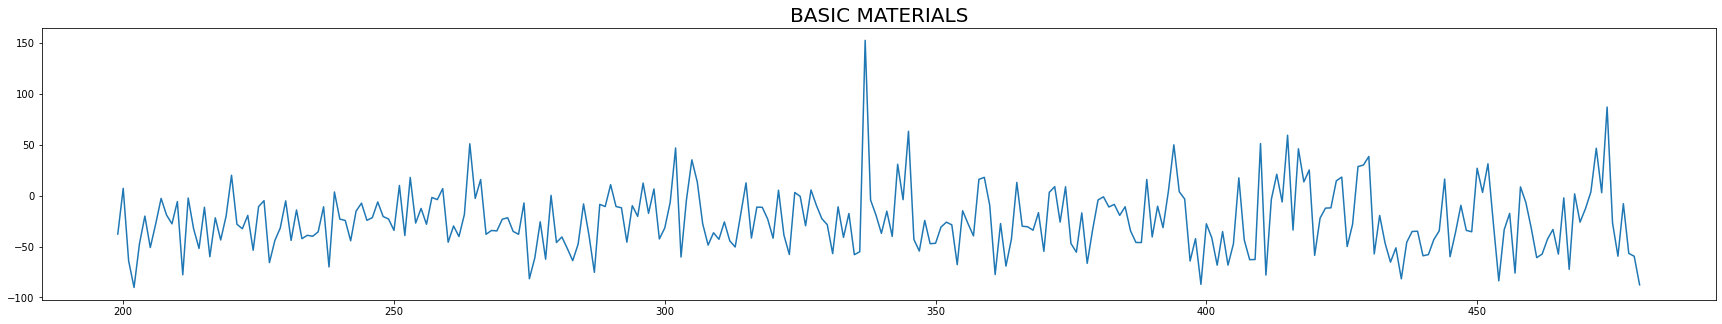

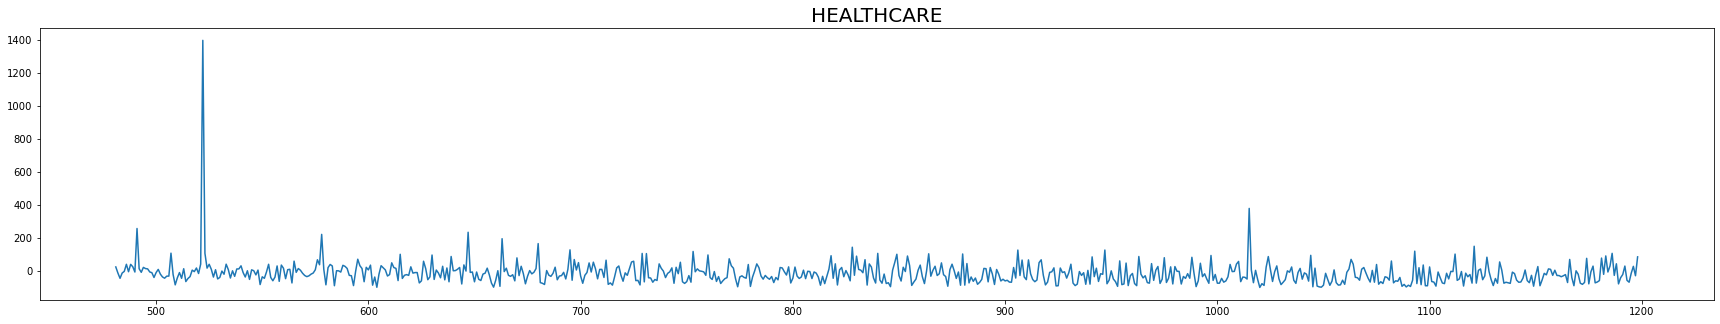

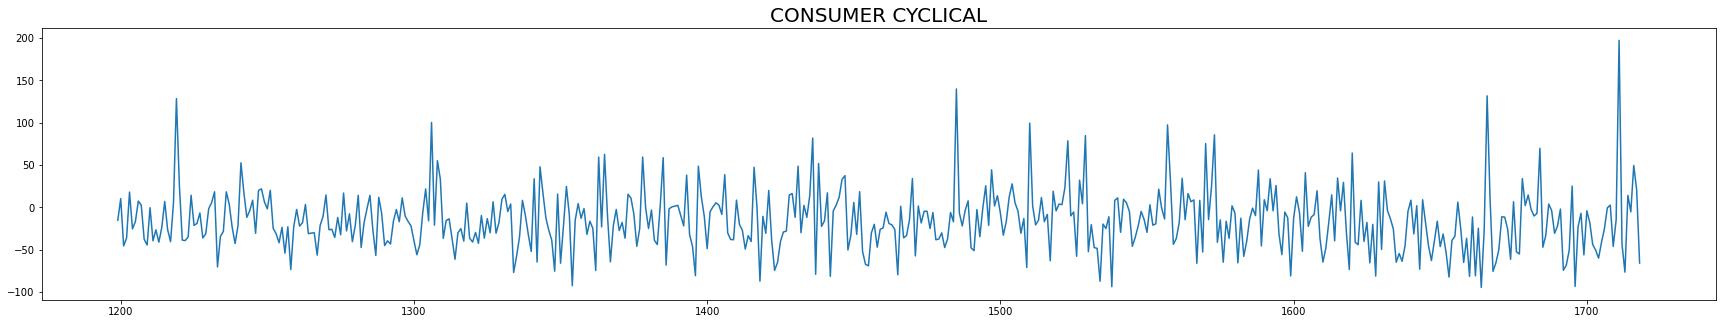

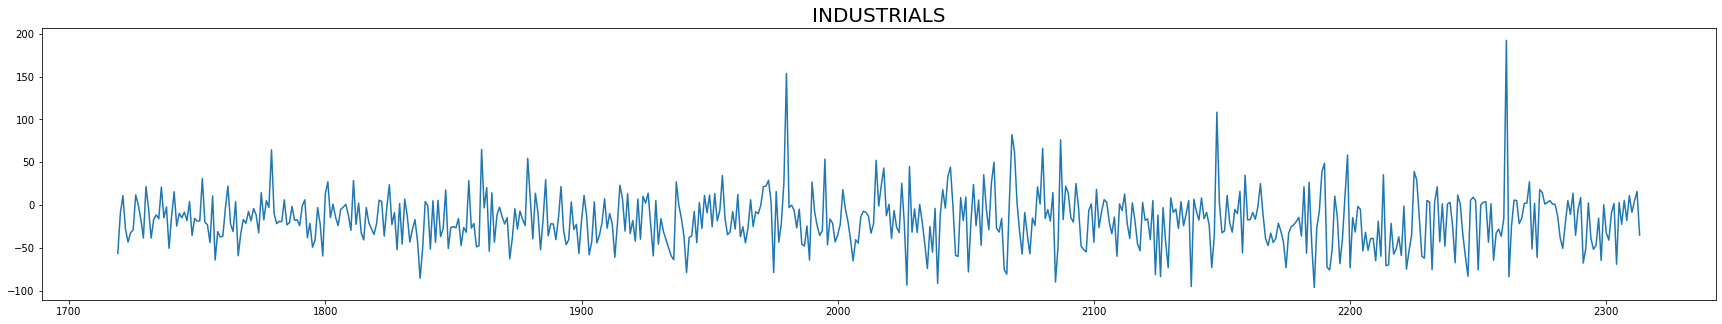

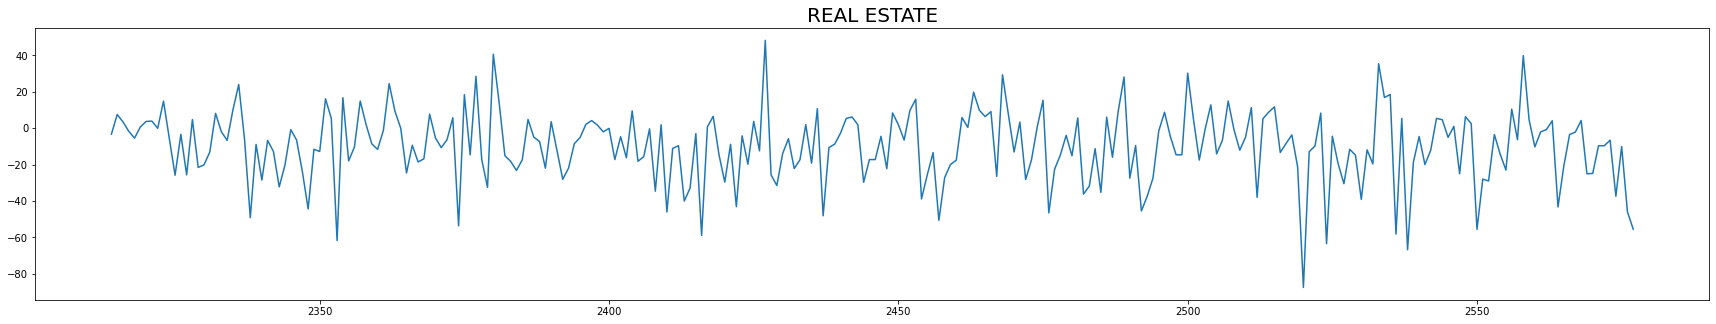

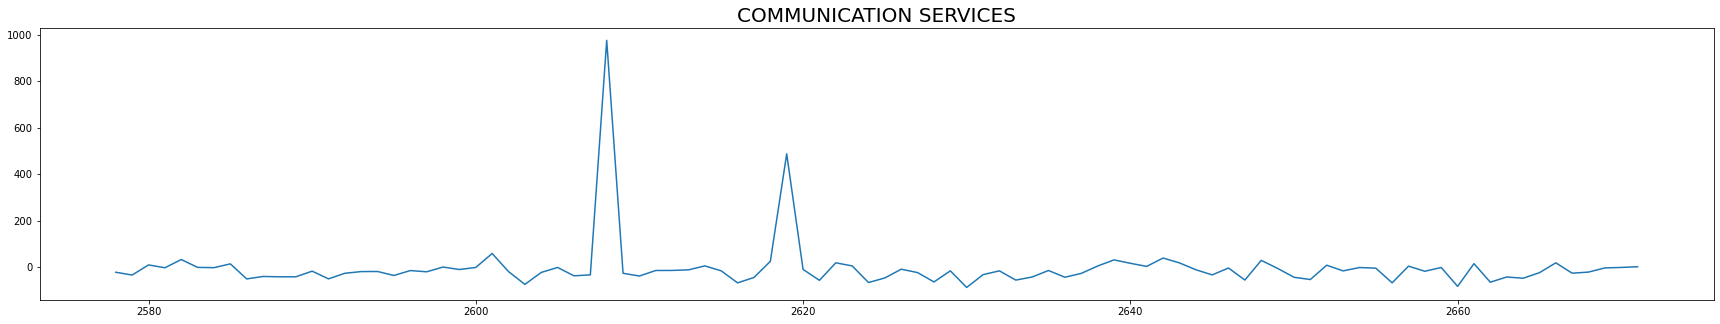

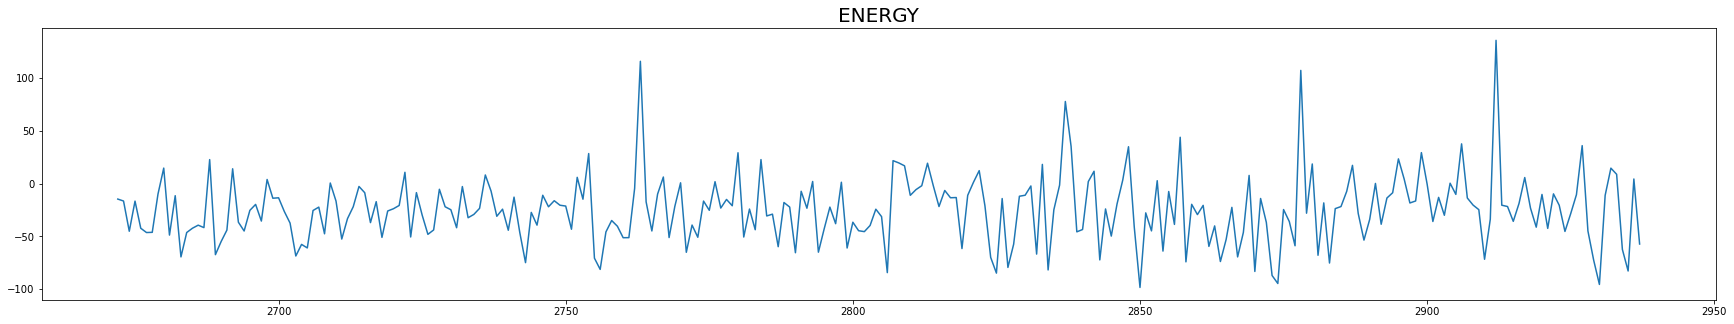

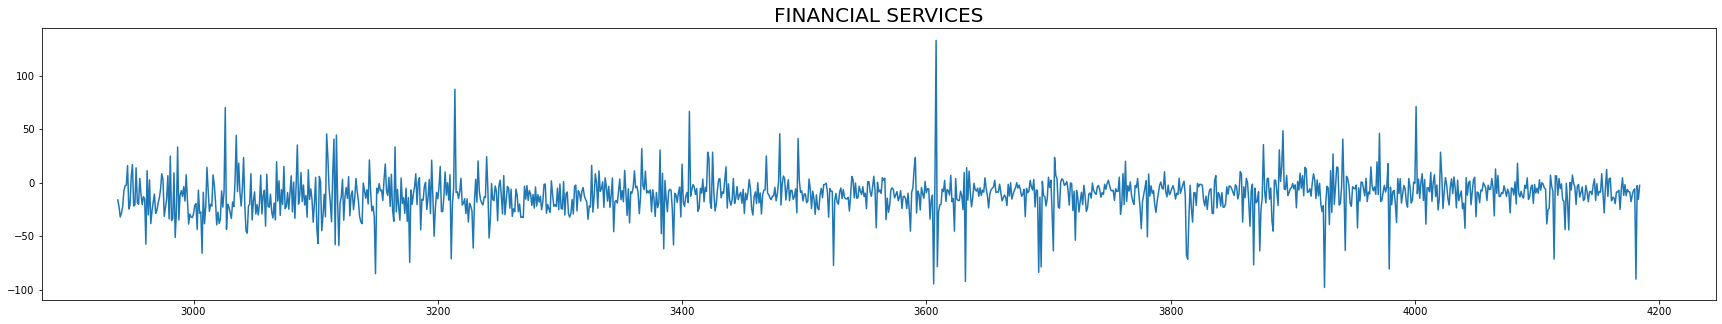

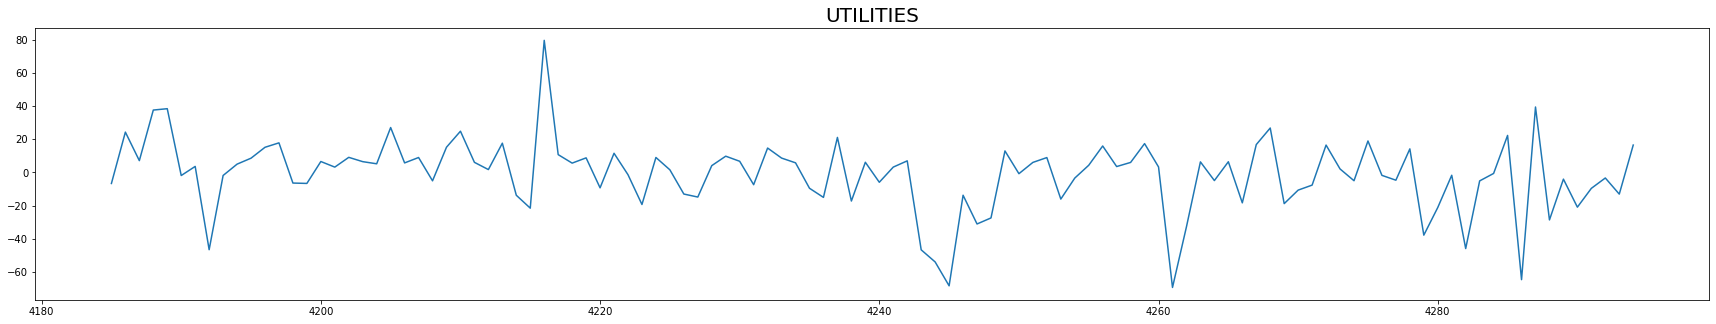

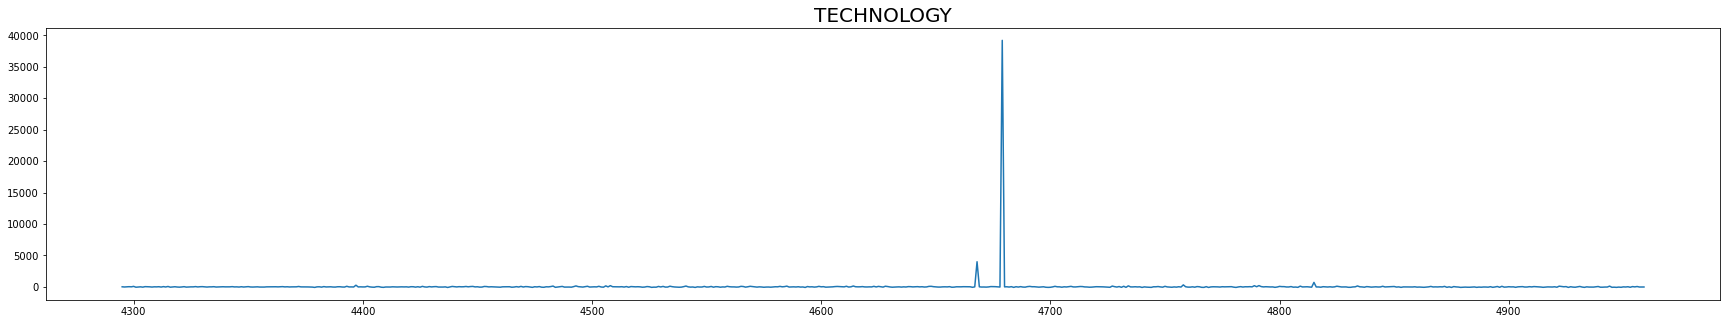

In [658]:
dfp = ds2014.loc[:, ['Sector', price]]
sector_list = dfp["Sector"].unique()
for sector in sector_list:

    temp = dfp[dfp['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp[price])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

### looking for missing values and how to handle them

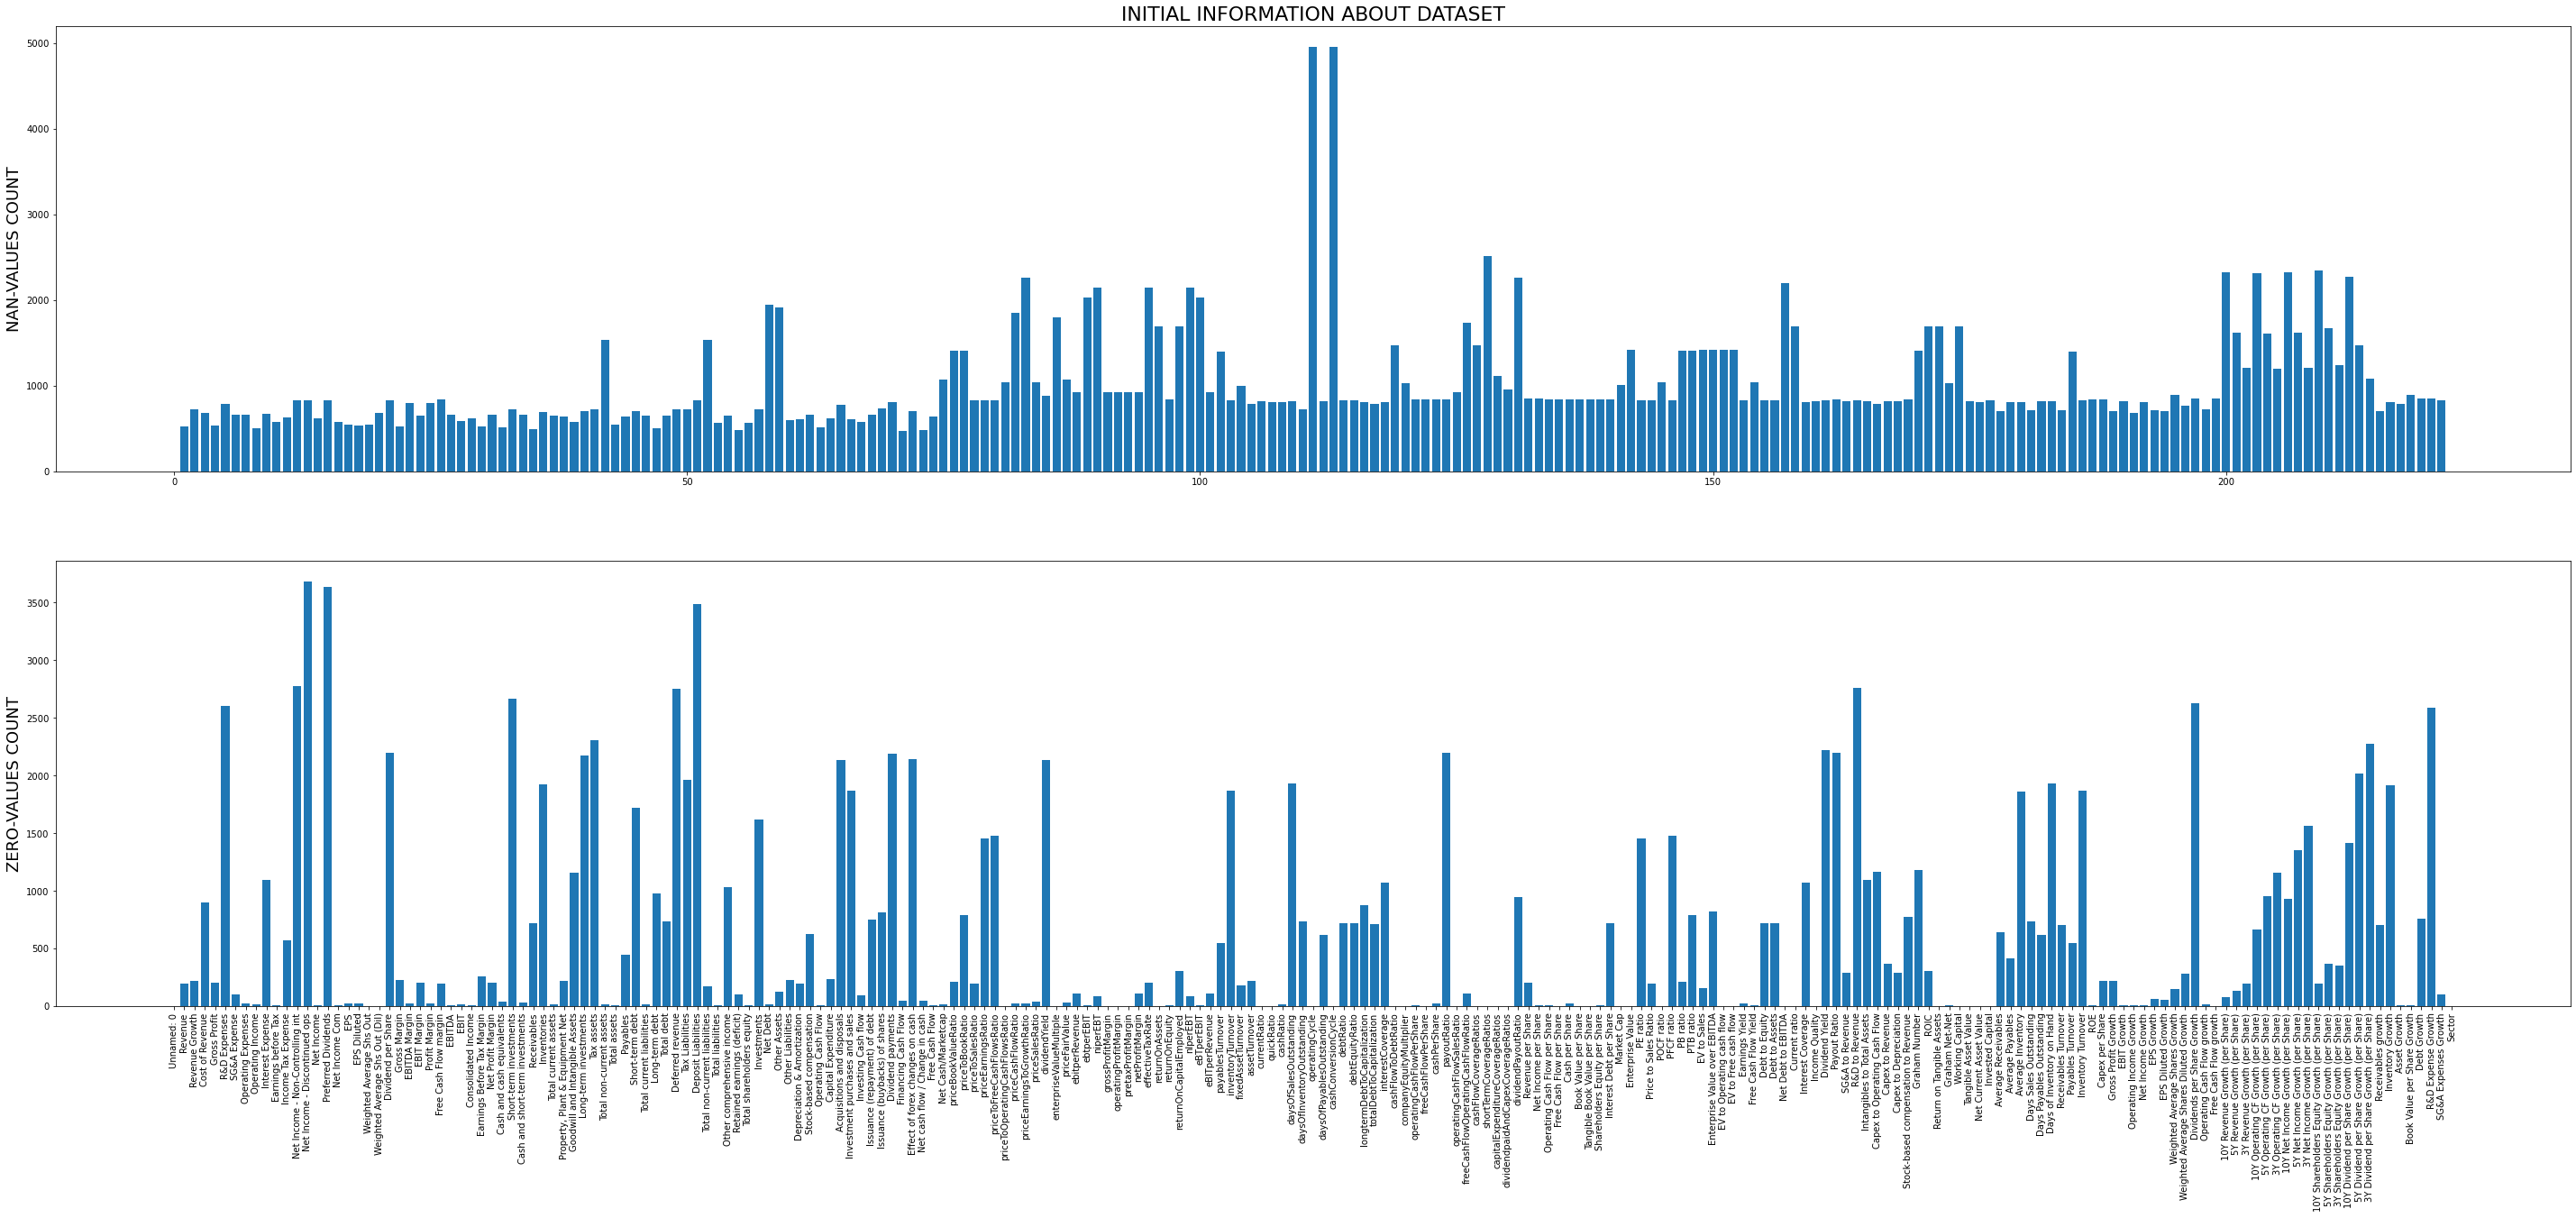

In [659]:
# Drop columns relative to classification, we will use them later
class_data = ds2014.loc[:, ['Class', price]]
ds2014.drop(['Class', price], inplace=True, axis=1)

# Plot initial status of data quality in terms of nan-values and zero-values
nan_vals = ds2014.isna().sum()
zero_vals = ds2014.isin([0]).sum()
ind = np.arange(ds2014.shape[1])

plt.figure(figsize=(50,20))

plt.subplot(2,1,1)
plt.title('INITIAL INFORMATION ABOUT DATASET', fontsize=22)
plt.bar(ind, nan_vals.values.tolist())
plt.ylabel('NAN-VALUES COUNT', fontsize=18)

plt.subplot(2,1,2)
plt.bar(ind, zero_vals.values.tolist())
plt.ylabel('ZERO-VALUES COUNT', fontsize=18)
plt.xticks(ind, nan_vals.index.values, rotation='90')

plt.show()

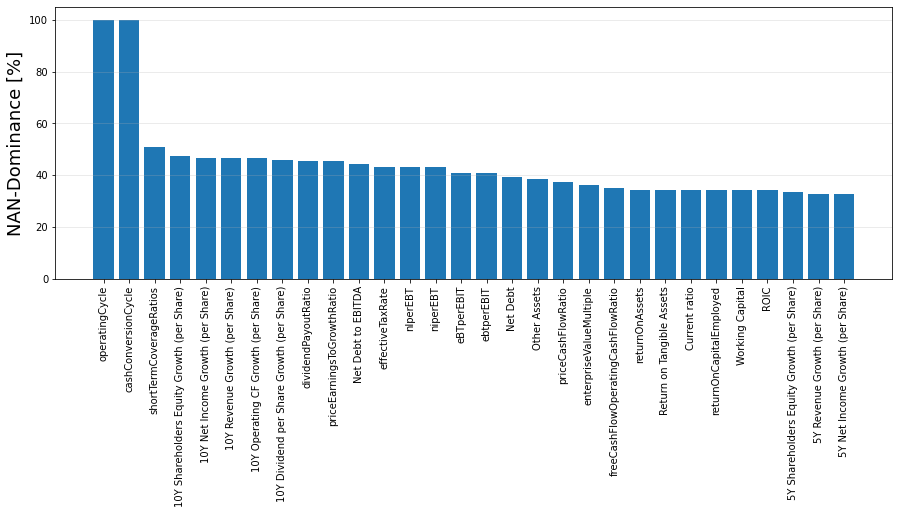

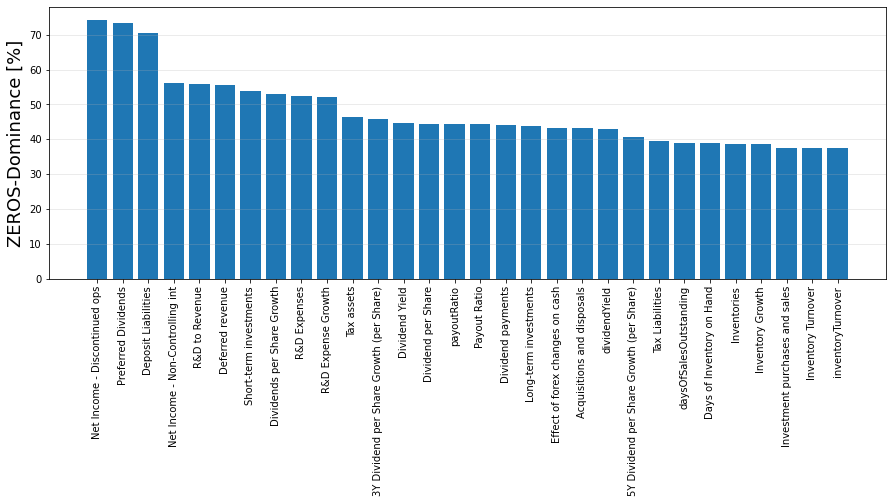

In [660]:
# Find count and percent of nan-values, zero-values
total_nans = ds2014.isnull().sum().sort_values(ascending=False)
percent_nans = (ds2014.isnull().sum()/ds2014.isnull().count() * 100).sort_values(ascending=False)
total_zeros = ds2014.isin([0]).sum().sort_values(ascending=False)
percent_zeros = (ds2014.isin([0]).sum()/ds2014.isin([0]).count() * 100).sort_values(ascending=False)
df_nans = pd.concat([total_nans, percent_nans], axis=1, keys=['Total NaN', 'Percent NaN'])
df_zeros = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total Zeros', 'Percent Zeros'])

# Graphical representation
plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_nans['Percent NaN'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_nans['Percent NaN'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('NAN-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('ZEROS-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

In [661]:
# Find reasonable threshold for nan-values situation
test_nan_level = 0.5
print(df_nans.quantile(test_nan_level))
_, thresh_nan = df_nans.quantile(test_nan_level)

# Find reasonable threshold for zero-values situation
test_zeros_level = 0.6
print(df_zeros.quantile(test_zeros_level))
_, thresh_zeros = df_zeros.quantile(test_zeros_level)

Total NaN      833.000000
Percent NaN     16.794355
Name: 0.5, dtype: float64
Total Zeros      292.200000
Percent Zeros      5.891129
Name: 0.6, dtype: float64


In [662]:
# Clean dataset applying thresholds for both zero values, nan-values
print(f'INITIAL NUMBER OF VARIABLES: {ds2014.shape[1]}')
print()

df_test1 = ds2014.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, 1)
print(f'NUMBER OF VARIABLES AFTER NaN THRESHOLD {thresh_nan:.2f}%: {df_test1.shape[1]}')
print()

df_zeros_postnan = df_zeros.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, axis=0)
df_test2 = df_test1.drop((df_zeros_postnan[df_zeros_postnan['Percent Zeros'] > thresh_zeros]).index, 1)
print(f'NUMBER OF VARIABLES AFTER Zeros THRESHOLD {thresh_zeros:.2f}%: {df_test2.shape[1]}')

INITIAL NUMBER OF VARIABLES: 223

NUMBER OF VARIABLES AFTER NaN THRESHOLD 16.79%: 114

NUMBER OF VARIABLES AFTER Zeros THRESHOLD 5.89%: 61


/var/folders/7k/9x94hbs904jgh5ymqv00n1rh0000gn/T/ipykernel_60387/3911516031.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_test1 = ds2014.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, 1)
/var/folders/7k/9x94hbs904jgh5ymqv00n1rh0000gn/T/ipykernel_60387/3911516031.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_test2 = df_test1.drop((df_zeros_postnan[df_zeros_postnan['Percent Zeros'] > thresh_zeros]).index, 1)


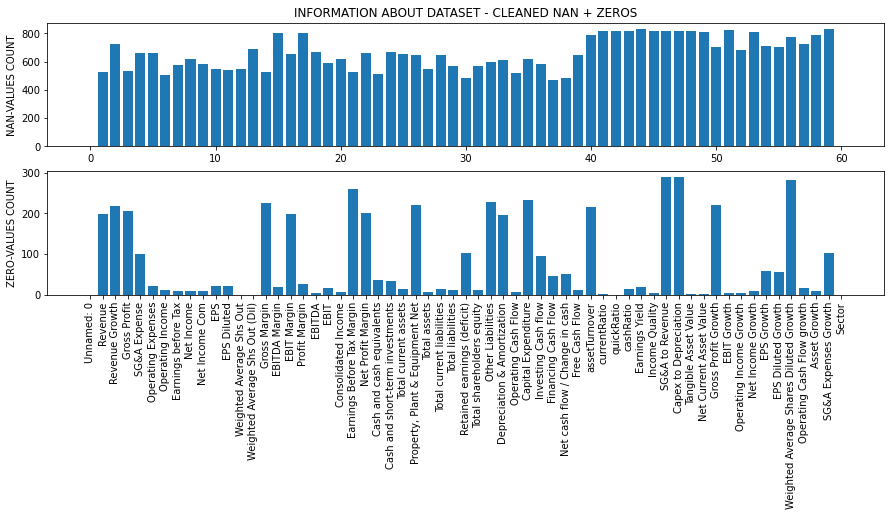

In [663]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('INFORMATION ABOUT DATASET - CLEANED NAN + ZEROS', fontsize=12)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isnull().sum())
plt.ylabel('NAN-VALUES COUNT', fontsize=10)

plt.subplot(2,1,2)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isin([0]).sum())
plt.ylabel('ZERO-VALUES COUNT', fontsize=10)
plt.xticks(np.arange(df_test2.shape[1]), df_test2.columns.values, rotation='90')

plt.show()

In [664]:
df_test2.describe()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,...,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
count,4.435000e+03,4236.000000,4.426000e+03,4.299000e+03,4.299000e+03,4.456000e+03,4.381000e+03,4.340000e+03,4.378000e+03,4.414000e+03,...,4256.000000,4135.000000,4275.000000,4150.000000,4246.000000,4253.000000,4188.000000,4238.000000,4168.000000,4132.000000
mean,5.085608e+09,0.953124,1.934378e+09,8.532075e+08,1.331302e+09,5.943889e+08,4.974142e+08,3.770531e+08,3.749310e+08,-1.371788e+03,...,2.451719,2.163818,-1.031819,-8.278726,1.198077,1.185323,0.691652,116.508516,1.084989,0.719938
std,3.148389e+10,18.956861,7.911822e+09,3.521939e+09,5.214527e+09,2.763764e+09,2.362747e+09,2.058431e+09,2.037733e+09,8.241842e+04,...,85.917984,416.065974,349.741421,524.538526,68.221059,68.149534,12.300433,7019.702499,32.740851,31.830424
min,-3.004500e+07,-6.872700,-8.138230e+08,-1.043667e+08,-1.088000e+09,-1.868300e+10,-1.819800e+10,-2.304500e+10,-2.304500e+10,-5.419062e+06,...,-9.800100,-16888.000000,-18881.000000,-33777.000000,-294.000000,-294.000000,-0.960300,-1085.062400,-1.000000,-2.369900
25%,5.900000e+07,0.000000,3.200000e+07,1.861650e+07,3.700850e+07,-4.376053e+06,-9.396000e+06,-9.532250e+06,-9.979750e+06,-3.800000e-01,...,-0.006125,-0.254600,-0.221300,-0.371950,-0.292150,-0.293700,-0.000500,-0.280375,-0.008050,-0.003925
50%,4.400000e+08,0.073050,1.993761e+08,8.360500e+07,1.638000e+08,3.739450e+07,2.464000e+07,1.900000e+07,1.869100e+07,6.185000e-01,...,0.072200,0.081300,0.072200,0.080800,0.105600,0.105600,0.011700,0.039850,0.066300,0.067250
75%,2.254111e+09,0.211625,8.823762e+08,3.711330e+08,6.229360e+08,2.604446e+08,1.976460e+08,1.616768e+08,1.600448e+08,2.090000e+00,...,0.238075,0.468500,0.409650,0.634650,0.682500,0.684200,0.093650,0.405475,0.203425,0.182500
max,1.695864e+12,825.959800,2.302870e+11,1.018530e+11,1.018530e+11,6.513565e+10,6.408900e+10,5.065541e+10,5.065541e+10,1.444920e+05,...,5470.750000,20598.428600,12839.142900,410.000000,4378.049200,4378.049200,602.231200,455999.000000,2014.273300,2042.000000


In [665]:
# Cut outliers
top_quantiles = df_test2.quantile(0.95)
outliers_top = (df_test2 > top_quantiles)

low_quantiles = df_test2.quantile(0.05)
outliers_low = (df_test2 < low_quantiles)

df_test2 = df_test2.mask(outliers_top, top_quantiles, axis=1)
df_test2 = df_test2.mask(outliers_low, low_quantiles, axis=1)

# Take a look at the dataframe post-outliers cut
df_test2.describe()

/var/folders/7k/9x94hbs904jgh5ymqv00n1rh0000gn/T/ipykernel_60387/385929963.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_top = (df_test2 > top_quantiles)
/var/folders/7k/9x94hbs904jgh5ymqv00n1rh0000gn/T/ipykernel_60387/385929963.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_low = (df_test2 < low_quantiles)


,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,...,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
count,4.435000e+03,4236.000000,4.426000e+03,4.299000e+03,4.299000e+03,4.456000e+03,4.381000e+03,4.340000e+03,4.378000e+03,4414.000000,...,4256.000000,4135.000000,4275.000000,4150.000000,4246.000000,4253.000000,4188.000000,4238.000000,4168.000000,4132.000000
mean,2.752054e+09,0.150853,1.041139e+09,4.596963e+08,7.097420e+08,3.335392e+08,2.730727e+08,2.172876e+08,2.178694e+08,0.850504,...,0.192106,0.137477,0.138974,0.128804,0.221177,0.220645,0.094952,0.135260,0.161533,0.117341
std,5.294401e+09,0.282268,1.968262e+09,8.904646e+08,1.303699e+09,7.121680e+08,6.222539e+08,5.024863e+08,5.065032e+08,2.509641,...,0.441252,1.127151,1.021115,1.360183,1.274437,1.274206,0.197559,0.968713,0.325634,0.217453
min,1.030303e+05,-0.238275,0.000000e+00,2.920782e+06,6.296898e+06,-9.236275e+07,-1.289210e+08,-1.290933e+08,-1.317726e+08,-4.510500,...,-0.386350,-2.423390,-2.092140,-3.103590,-2.570225,-2.571400,-0.051900,-1.782675,-0.224945,-0.194790
25%,5.900000e+07,0.000000,3.200000e+07,1.861650e+07,3.700850e+07,-4.376053e+06,-9.396000e+06,-9.532250e+06,-9.979750e+06,-0.380000,...,-0.006125,-0.254600,-0.221300,-0.371950,-0.292150,-0.293700,-0.000500,-0.280375,-0.008050,-0.003925
50%,4.400000e+08,0.073050,1.993761e+08,8.360500e+07,1.638000e+08,3.739450e+07,2.464000e+07,1.900000e+07,1.869100e+07,0.618500,...,0.072200,0.081300,0.072200,0.080800,0.105600,0.105600,0.011700,0.039850,0.066300,0.067250
75%,2.254111e+09,0.211625,8.823762e+08,3.711330e+08,6.229360e+08,2.604446e+08,1.976460e+08,1.616768e+08,1.600448e+08,2.090000,...,0.238075,0.468500,0.409650,0.634650,0.682500,0.684200,0.093650,0.405475,0.203425,0.182500
max,2.073624e+10,1.022200,7.719079e+09,3.559300e+09,5.175800e+09,2.781000e+09,2.426000e+09,1.949153e+09,1.964800e+09,6.443500,...,1.618800,3.057760,2.857900,3.350635,3.454225,3.458140,0.745075,2.779720,1.182825,0.731535


In [666]:
# Replace nan-values with mean value of column, considering each sector individually. Remove Price Var that are bigger than 400, since it does not make too much sense of companies making more than 400% a year
df_test2 = df_test2.join(class_data)
df_test2 = df_test2[df_test2[price]<outliers_percentage]
df_test2 = df_test2.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))

/var/folders/7k/9x94hbs904jgh5ymqv00n1rh0000gn/T/ipykernel_60387/1796677956.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  df_test2 = df_test2.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))


In [667]:
# Add the sector column
df_out = df_test2.join(ds2014['Sector'])

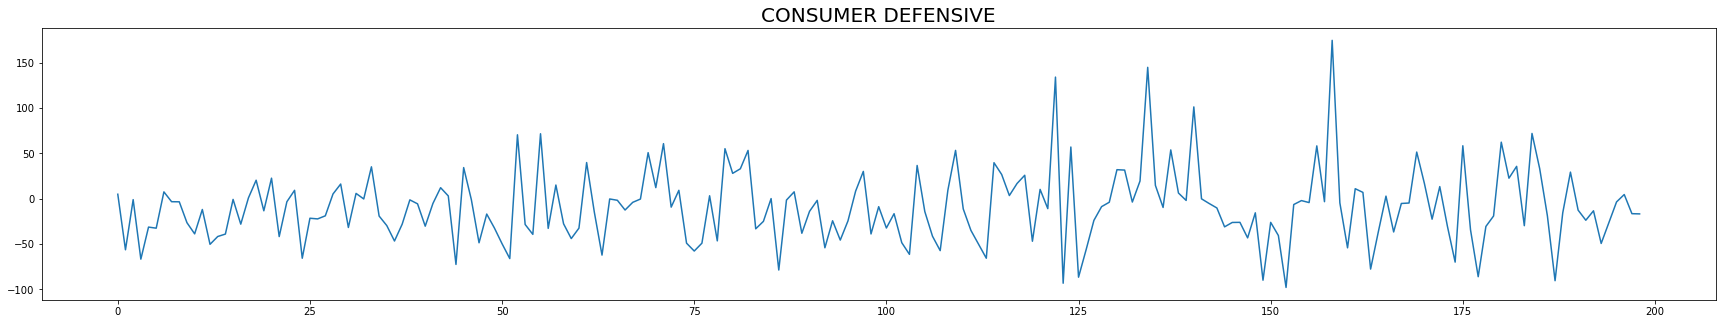

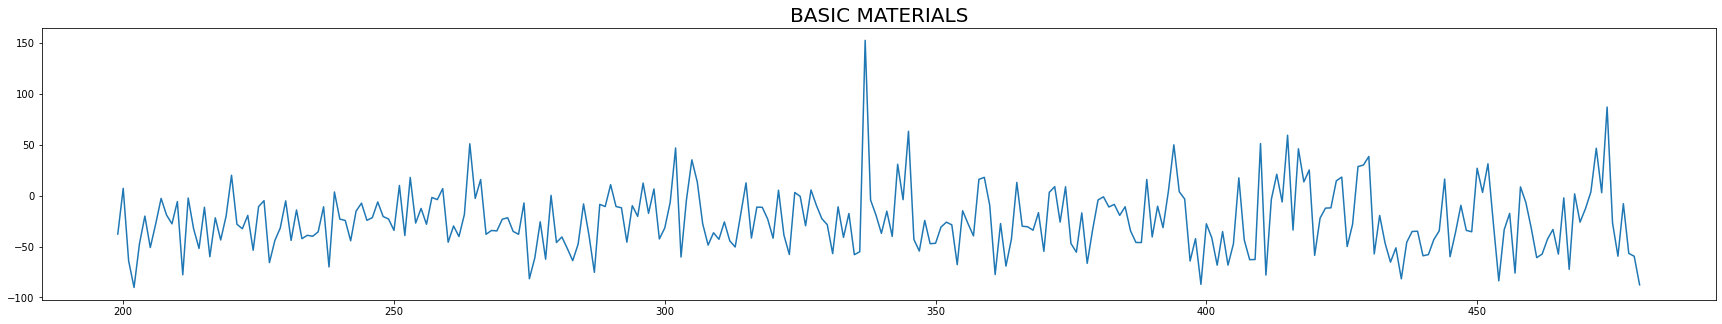

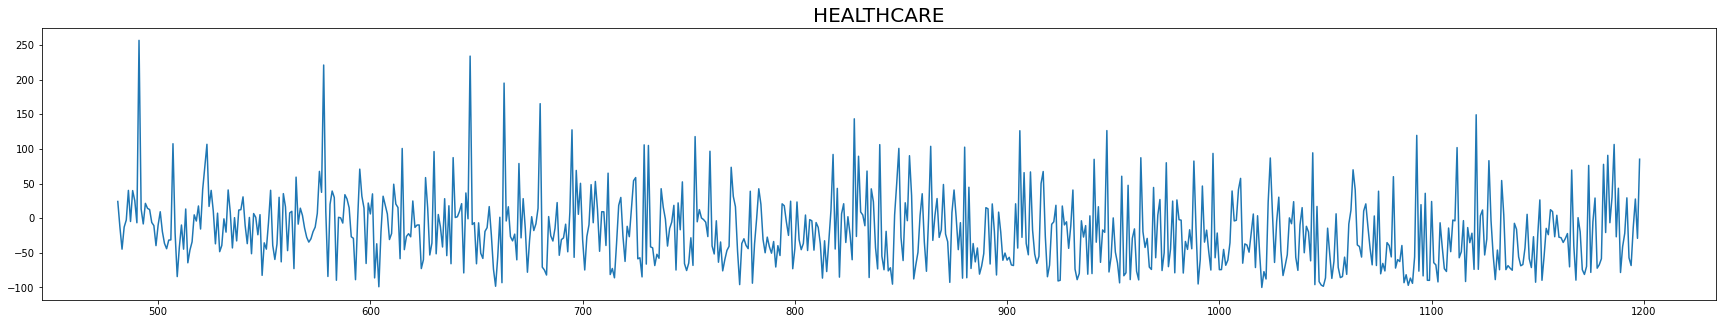

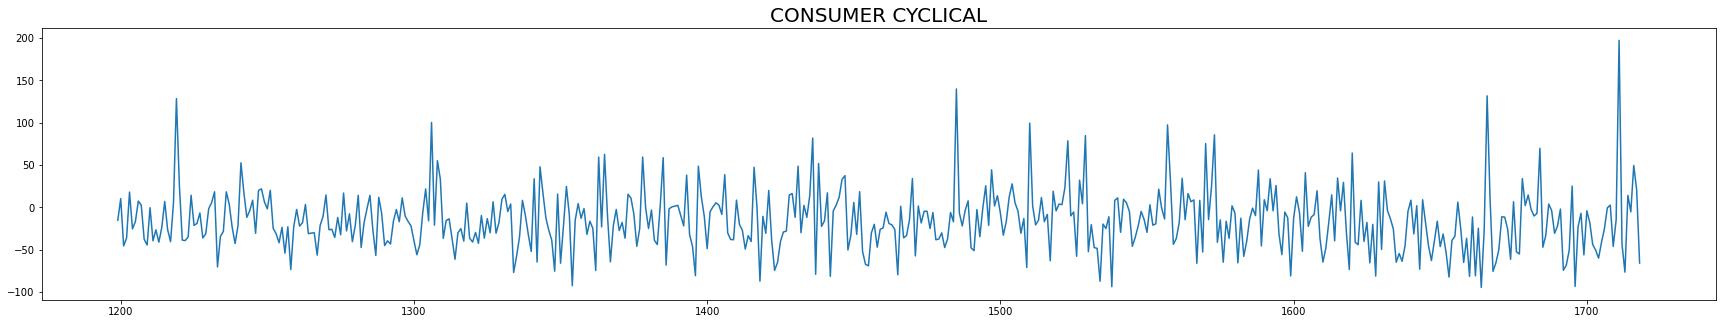

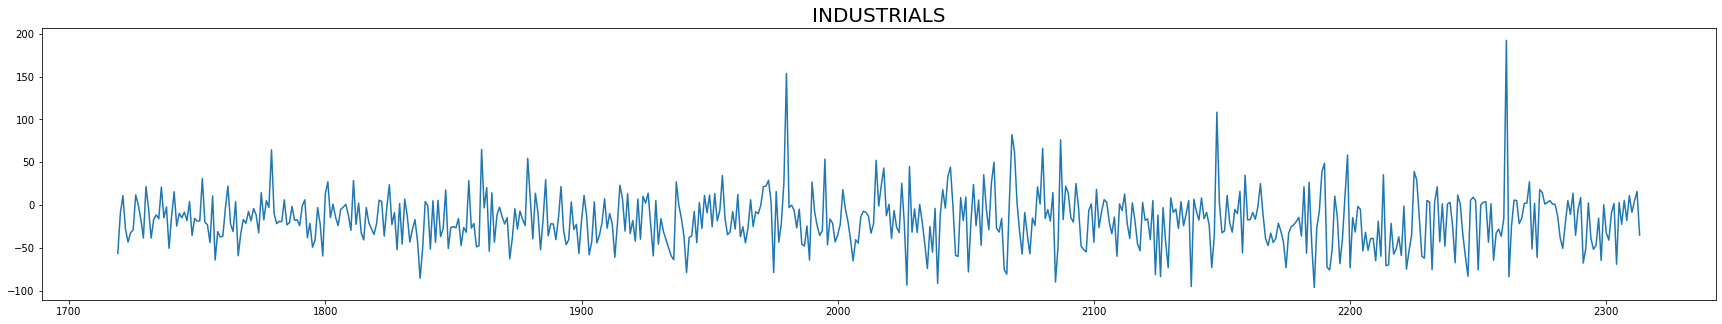

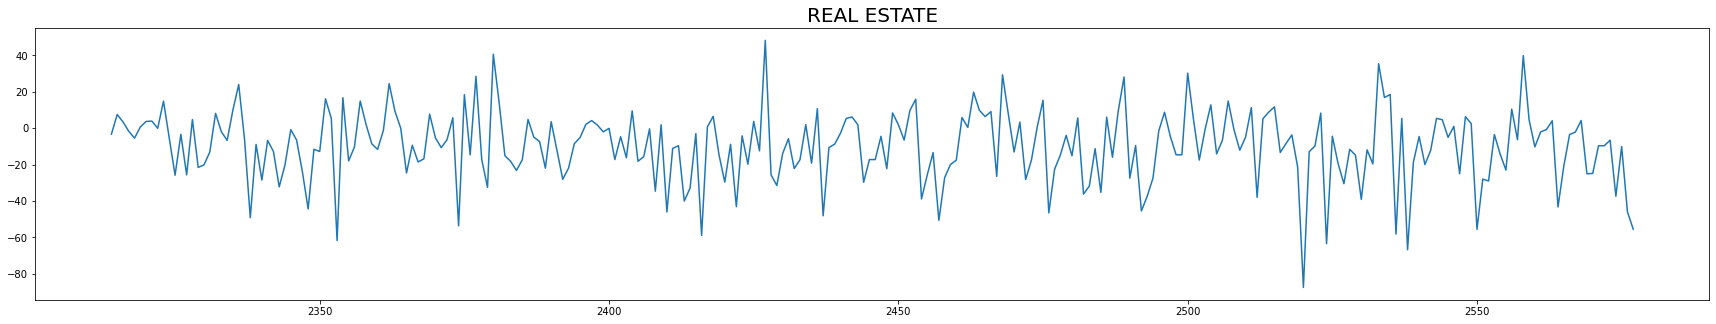

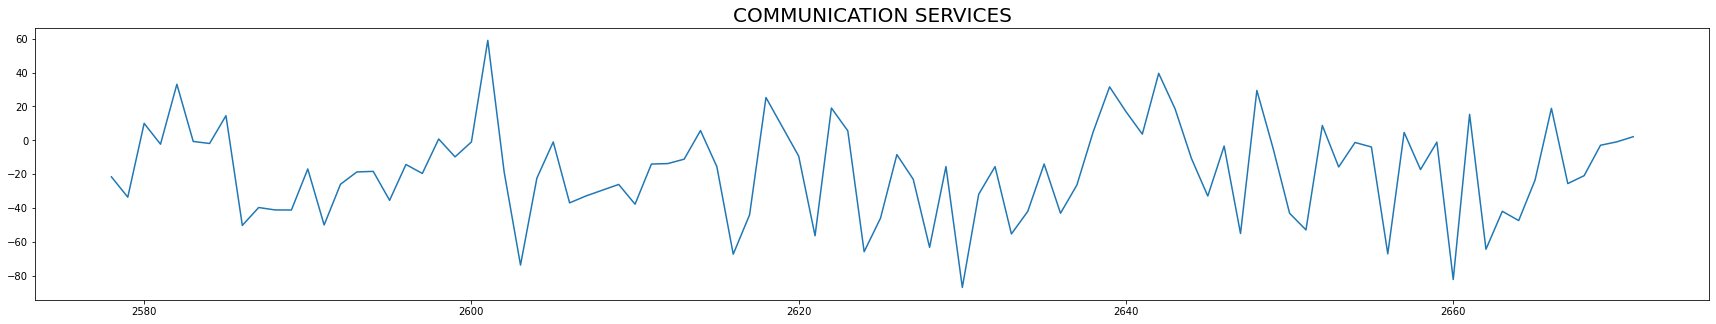

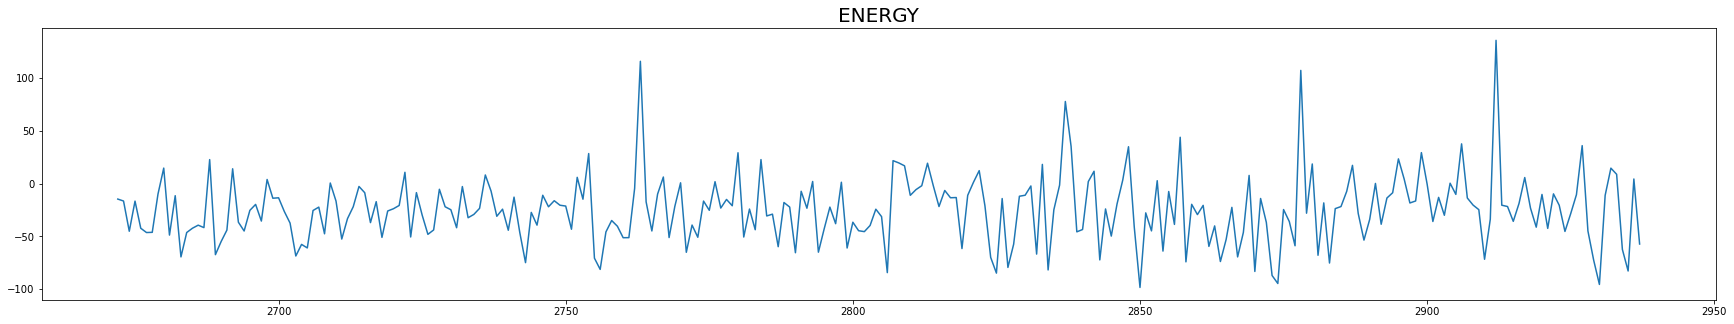

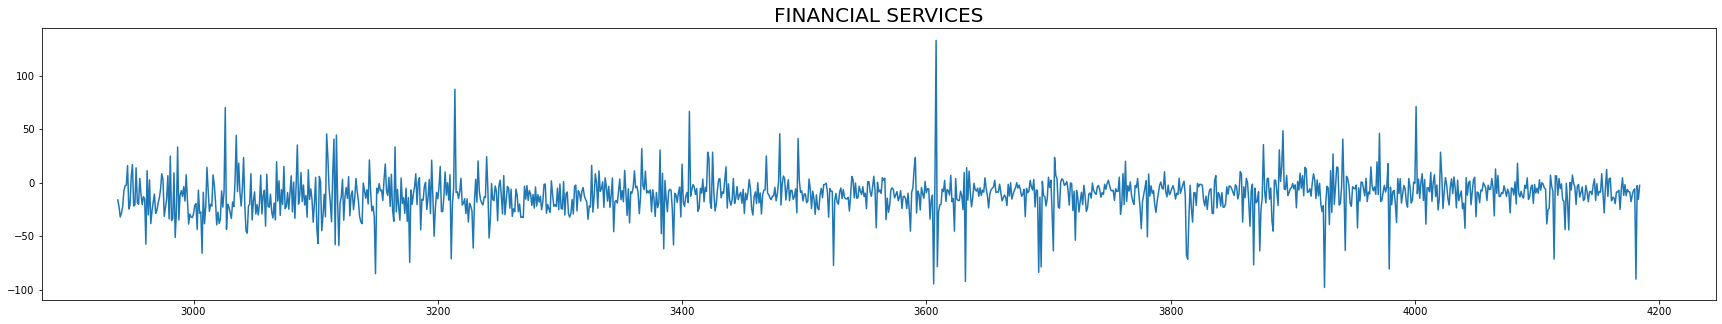

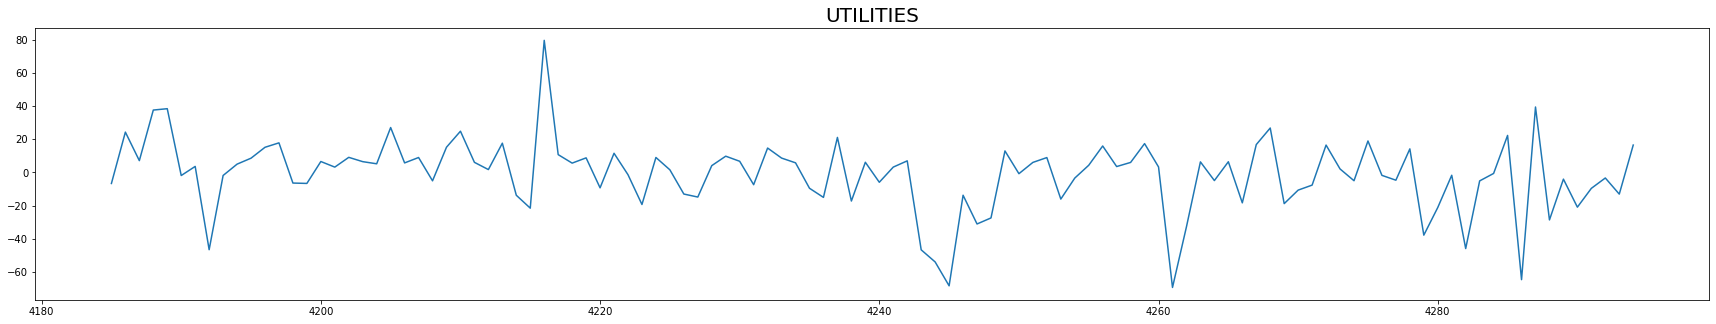

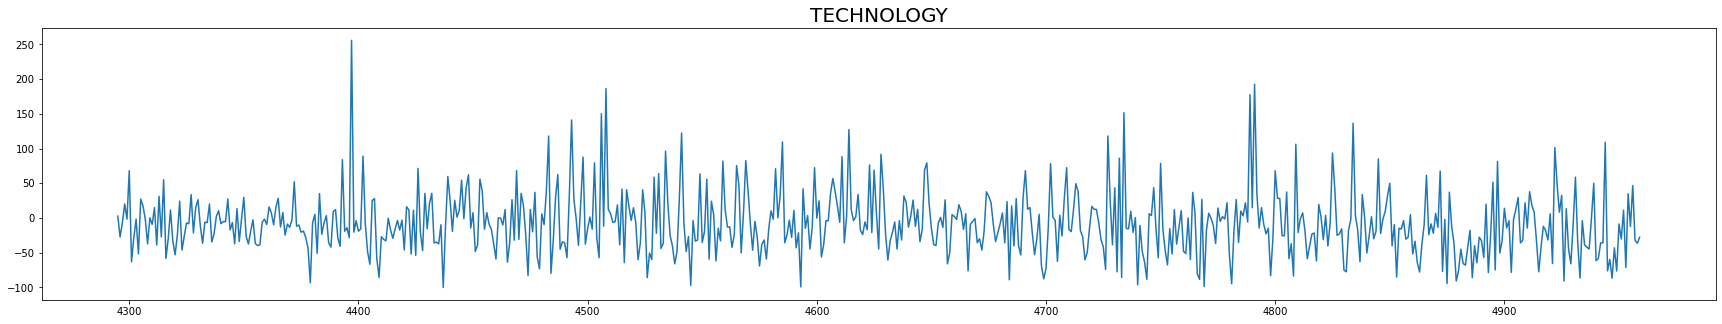

In [668]:
# Handle outliers which have more than 500% gain per year
#df_out = (df_out[df_out["2016 PRICE VAR [%]"]<500])
dfp = df_out.loc[:, ['Sector', price]]
sector_list = dfp["Sector"].unique()
for sector in sector_list:

    temp = dfp[dfp['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp[price])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [669]:
df_out.loc[df_out[price]>sp500_2015_buy, "Class"] = 2
df_out.loc[df_out[price]<sp500_2015_sell, "Class"] = 0
df_out.loc[(df_out[price] >= sp500_2015_sell) & (df_out[price]<=sp500_2015_buy), "Class"] = 1

In [670]:
# Save the cleaned data as ned .csv file
df_out.to_csv(fileName)